# Setup

## Importing Packages

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

## Loading Data

In [2]:
trip_df = pd.read_csv('D:\\CDS590\\data\\processed\\trip_segments_feb_march_april_may.csv')
weather_df = pd.read_csv('D:\\CDS590\\data\\raw\\combined_weather_data.csv')

In [3]:
trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   route_id       552 non-null    int64  
 1   start_time     552 non-null    object 
 2   end_time       552 non-null    object 
 3   start_hour     552 non-null    int64  
 4   end_hour       552 non-null    int64  
 5   start_stop     552 non-null    object 
 6   end_stop       552 non-null    object 
 7   start_stop_id  552 non-null    object 
 8   end_stop_id    552 non-null    object 
 9   start_lat      552 non-null    float64
 10  start_lon      552 non-null    float64
 11  end_lat        552 non-null    float64
 12  end_lon        552 non-null    float64
 13  duration       552 non-null    float64
 14  distance       552 non-null    float64
dtypes: float64(6), int64(3), object(6)
memory usage: 64.8+ KB


## Feature Extraction 

In [4]:
def calculate_operation_minutes(start_time):
    morning_start = pd.Timestamp(start_time.date()).replace(hour=6, minute=30)
    afternoon_start = pd.Timestamp(start_time.date()).replace(hour=15, minute=0)
    
    if start_time < afternoon_start:  # Morning session
        return max(0, (start_time - morning_start).total_seconds() // 60 + 1)
    else:  # Afternoon session
        return (start_time - afternoon_start).total_seconds() // 60 + 181
    
def preprocess_weather_data(df):
    # Convert date and time columns to datetime
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['utc_time'])
    
    # Drop unnecessary columns
    columns_to_drop = ['date', 'utc_time', 'local_time']
    df = df.drop(columns=columns_to_drop)
    
    return df

# Convert start_time and end_time to datetime
trip_df['start_time'] = pd.to_datetime(trip_df['start_time'])
trip_df['end_time'] = pd.to_datetime(trip_df['end_time'])

# Extract day of week and month
trip_df['day_of_week'] = trip_df['start_time'].dt.dayofweek
trip_df['month'] = trip_df['start_time'].dt.month
    
# Calculate average speed (km/h)
trip_df['avg_speed'] = trip_df['distance'] / (trip_df['duration'] / 60)
    
# Remove rows with zero distance or duration
trip_df = trip_df[(trip_df['distance'] > 0) & (trip_df['duration'] > 0)]
    
# Cyclic encoding for day of week
trip_df['day_of_week_sin'] = np.sin(trip_df['day_of_week'] * (2 * np.pi / 7))
trip_df['day_of_week_cos'] = np.cos(trip_df['day_of_week'] * (2 * np.pi / 7))

# Calculate minutes of operation
trip_df['minutes_of_operation'] = trip_df['start_time'].apply(calculate_operation_minutes)
    
# Cyclic encoding for minutes of operation
trip_df['minutes_sin'] = np.sin(2 * np.pi * trip_df['minutes_of_operation'] / 360)
trip_df['minutes_cos'] = np.cos(2 * np.pi * trip_df['minutes_of_operation'] / 360)

weather_df = preprocess_weather_data(weather_df)

# Merge GPS and weather data
merged_df = pd.merge_asof(trip_df.sort_values('start_time'), 
                          weather_df.sort_values('datetime'), 
                          left_on='start_time', 
                          right_on='datetime', 
                          direction='nearest')

In [5]:
merged_df

,route_id,start_time,end_time,start_hour,end_hour,start_stop,end_stop,start_stop_id,end_stop_id,start_lat,...,avg_temp_C,temperature,feels_like,precip_mm,humidity,visibility,pressure,cloud_cover,wind_speed,datetime
0,10,2024-02-01 06:54:08,2024-02-01 07:00:07,6,7,SPBU Tlogomas,SD Dinoyo 2,BT01,BT02,-7.93324,...,22,18,18,0.0,90,10,1014,40,3,2024-02-01 06:00:00
1,10,2024-02-01 07:00:07,2024-02-01 07:09:44,7,7,SD Dinoyo 2,SMA 9,BT02,BT03,-7.94329,...,22,18,18,0.0,90,10,1014,40,3,2024-02-01 06:00:00
2,10,2024-02-01 07:09:44,2024-02-01 07:11:05,7,7,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,...,22,18,18,0.0,90,10,1014,40,3,2024-02-01 06:00:00
3,10,2024-02-01 07:11:05,2024-02-01 07:15:01,7,7,SD Dinoyo 2,SMA 8,BT02,BT04,-7.94329,...,22,18,18,0.0,90,10,1014,40,3,2024-02-01 06:00:00
4,10,2024-02-01 07:15:01,2024-02-01 07:21:56,7,7,SMA 8,MAN 2,BT04,BT05,-7.95658,...,22,18,18,0.0,90,10,1014,40,3,2024-02-01 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,10,2024-05-31 07:12:49,2024-05-31 07:14:20,7,7,SMA 9,SD Dinoyo 2,BT03,BT02,-7.94979,...,25,23,25,0.0,88,10,1013,8,5,2024-05-31 06:00:00
548,10,2024-05-31 07:14:20,2024-05-31 07:18:16,7,7,SD Dinoyo 2,SMA 8,BT02,BT04,-7.94329,...,25,23,25,0.0,88,10,1013,8,5,2024-05-31 06:00:00
549,10,2024-05-31 07:18:16,2024-05-31 07:24:57,7,7,SMA 8,MAN 2,BT04,BT05,-7.95658,...,25,23,25,0.0,88,10,1013,8,5,2024-05-31 06:00:00
550,10,2024-05-31 07:24:57,2024-05-31 07:26:24,7,7,MAN 2,SMA Dempo,BT05,BT06,-7.96334,...,25,23,25,0.0,88,10,1013,8,5,2024-05-31 06:00:00


In [6]:
# Calculate average speed for each unique minutes_cos value
avg_speed_per_minutes_cos = merged_df.groupby('minutes_cos')['avg_speed'].mean()
print(avg_speed_per_minutes_cos)


minutes_cos
-0.999848     9.081194
-0.998630    13.350131
-0.992546    13.218324
-0.984808     9.875439
-0.965926    21.229159
               ...    
 0.945519    26.323856
 0.951057    39.701346
 0.956305    23.861492
 0.965926    26.189442
 0.984808    11.092636
Name: avg_speed, Length: 126, dtype: float64


# Correlation Analysis

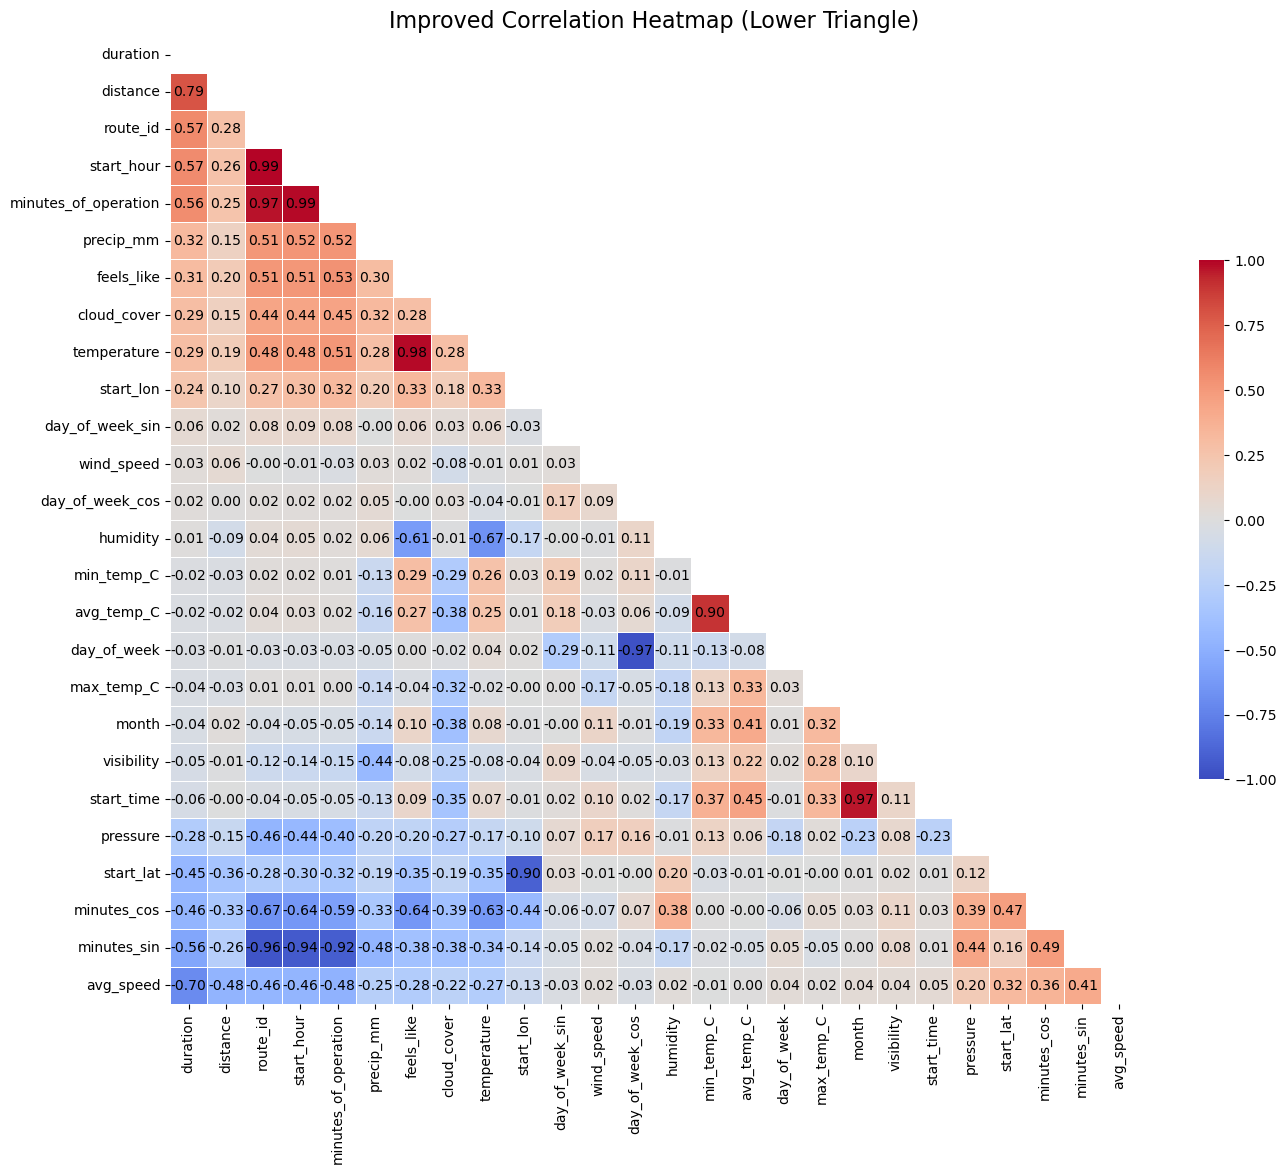


Correlations with duration
duration                1.000000
distance                0.794745
route_id                0.574175
start_hour              0.567088
minutes_of_operation    0.558314
precip_mm               0.321018
feels_like              0.310526
cloud_cover             0.294803
temperature             0.293711
start_lon               0.239504
day_of_week_sin         0.060060
wind_speed              0.027707
day_of_week_cos         0.019255
humidity                0.014701
min_temp_C             -0.017701
avg_temp_C             -0.024840
day_of_week            -0.030526
max_temp_C             -0.039033
month                  -0.039937
visibility             -0.054905
start_time             -0.056432
pressure               -0.281730
start_lat              -0.447896
minutes_cos            -0.464020
minutes_sin            -0.562083
avg_speed              -0.698207
Name: duration, dtype: float64


,route_id,start_time,start_hour,start_lat,start_lon,distance,day_of_week,month,avg_speed,avg_temp_C,...,max_temp_C,min_temp_C,cloud_cover,wind_speed,day_of_week_sin,day_of_week_cos,minutes_of_operation,minutes_sin,minutes_cos,duration
route_id,1.000000,-0.038907,0.992463,-0.276623,0.267315,0.277402,-0.032230,-0.039892,-0.460757,0.035641,...,0.014568,0.017945,0.442149,-0.003920,0.079576,0.017256,0.974047,-0.955067,-0.665653,0.574175
start_time,-0.038907,1.000000,-0.046733,0.005037,-0.010363,-0.001915,-0.012855,0.968049,0.054566,0.449307,...,0.332212,0.373464,-0.352565,0.099306,0.020993,0.015000,-0.053105,0.008884,0.031097,-0.056432
start_hour,0.992463,-0.046733,1.000000,-0.297393,0.296504,0.263666,-0.031323,-0.049097,-0.464698,0.034011,...,0.009421,0.016949,0.441712,-0.014766,0.085848,0.015997,0.988316,-0.936713,-0.636290,0.567088
start_lat,-0.276623,0.005037,-0.297393,1.000000,-0.901378,-0.358860,-0.005424,0.005583,0.316088,-0.011944,...,-0.004394,-0.034838,-0.194387,-0.005802,0.033653,-0.002446,-0.321804,0.157900,0.471051,-0.447896
start_lon,0.267315,-0.010363,0.296504,-0.901378,1.000000,0.104860,0.015540,-0.012187,-0.126963,0.012276,...,-0.001145,0.033530,0.184250,0.008735,-0.027174,-0.007058,0.323924,-0.140726,-0.436506,0.239504
distance,0.277402,-0.001915,0.263666,-0.358860,0.104860,1.000000,-0.013654,0.017025,-0.475864,-0.024209,...,-0.033763,-0.030207,0.154277,0.059251,0.024784,0.004489,0.254180,-0.264499,-0.328853,0.794745
day_of_week,-0.032230,-0.012855,-0.031323,-0.005424,0.015540,-0.013654,1.000000,0.014717,0.035797,-0.084230,...,0.033707,-0.127770,-0.021231,-0.105276,-0.287340,-0.969662,-0.032399,0.053677,-0.058874,-0.030526
month,-0.039892,0.968049,-0.049097,0.005583,-0.012187,0.017025,0.014717,1.000000,0.039346,0.409826,...,0.316036,0.329183,-0.383506,0.112766,-0.004494,-0.011013,-0.052833,0.004874,0.033993,-0.039937
avg_speed,-0.460757,0.054566,-0.464698,0.316088,-0.126963,-0.475864,0.035797,0.039346,1.000000,0.000956,...,0.020007,-0.005506,-0.222759,0.023636,-0.030555,-0.032448,-0.478397,0.406331,0.358984,-0.698207
avg_temp_C,0.035641,0.449307,0.034011,-0.011944,0.012276,-0.024209,-0.084230,0.409826,0.000956,1.000000,...,0.329448,0.900181,-0.382727,-0.028475,0.182036,0.061905,0.019873,-0.045832,-0.004345,-0.024840


In [21]:
def correlation_heatmap(data, target_column='duration', figsize=(14, 12)):
    # Select relevant features
    features_to_keep = ['route_id', 'start_time', 'start_hour', 'start_lat', 'start_lon', 
                        'distance', 'day_of_week', 'month', 'avg_speed', 'avg_temp_C', 'temperature',
                        'feels_like', 'precip_mm', 'humidity', 'visibility', 'pressure', 'max_temp_C', 'min_temp_C',
                        'cloud_cover', 'wind_speed', 'day_of_week_sin', 
                        'day_of_week_cos', 'minutes_of_operation', 'minutes_sin', 'minutes_cos', target_column]
    
    # Check which features are actually in the dataframe
    available_features = [f for f in features_to_keep if f in data.columns]
    missing_features = [f for f in features_to_keep if f not in data.columns]
    
    if missing_features:
        print(f"Warning: The following features are not in the dataframe: {missing_features}")
    
    df = data[available_features].copy()
    
    # Identify numerical features
    numerical_features = df.select_dtypes(include=[np.number]).columns
    
    # Normalize numerical features
    for feature in numerical_features:
        if df[feature].std() != 0:
            df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
        else:
            print(f"Warning: Feature '{feature}' has zero standard deviation and cannot be normalized.")
    
    # Calculate correlations
    corr_matrix = df.corr()
    
    # Sort features by correlation with target
    corr_with_target = corr_matrix[target_column].sort_values(ascending=False)
    sorted_features = corr_with_target.index
    
    # Create a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Plot heatmap
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(corr_matrix.loc[sorted_features, sorted_features], 
                          mask=mask,
                          cmap='coolwarm', vmin=-1, vmax=1, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    # Manually add annotations to avoid the warning
    for i in range(len(sorted_features)):
        for j in range(i):
            plt.text(j + 0.5, i + 0.5, f"{corr_matrix.loc[sorted_features[i], sorted_features[j]]:.2f}",
                     ha='center', va='center', color='black')
    
    plt.title("Improved Correlation Heatmap (Lower Triangle)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print("\nCorrelations with", target_column)
    print(corr_with_target)
    
    return corr_matrix


correlation_heatmap(merged_df)

**Highlights**:

1. Strong Correlations with Duration (target variable):
   - Distance (0.81): This is the strongest predictor of duration, which is logical as longer distances typically take more time.
   - Route_id (-0.58): Suggests that certain routes are associated with shorter or longer durations.
   - Start_hour (-0.57) and Minutes_of_operation (-0.56): Time-related features have a strong influence on duration.
   - Avg_speed (-0.70): Higher average speeds are associated with shorter durations, as expected.

2. Multicollinearity:
   - Start_hour and Minutes_of_operation (0.99): These are highly correlated and likely redundant.
   - Minutes_sin and Start_hour (-0.96): Another high correlation with time-related features.
   - Start_lat and Start_lon (-0.90): Strong correlation between latitude and longitude.

3. Weather-related features:
   - Feels_like, Precip_mm, and Cloud_cover have moderate correlations with duration (around 0.30).
   - Other weather features (humidity, avg_temp_C, wind_speed) have weak correlations with duration.

4. Cyclical features:
   - Day_of_week_sin and Day_of_week_cos have very weak correlations with duration.
   - Minutes_sin and Minutes_cos have stronger correlations with duration (-0.56 and -0.48 respectively).

# Data Splitting

In [14]:
def engineer_features(df):
    # Create a copy of the dataframe to avoid modifying the original
    df_engineered = df.copy()
    
    # 1. Bin Avg_speed into categories
    def categorize_speed(speed):
        threshold = 30
        if speed < threshold:
            return 0
        else:
            return 1
    
    df_engineered['Speed_Category'] = df_engineered['avg_speed'].apply(categorize_speed)
    
    label_encoder = LabelEncoder()
    df_engineered['start_stop_id_encoded'] = label_encoder.fit_transform(merged_df['start_stop_id'])
    df_engineered['end_stop_id_encoded'] = label_encoder.fit_transform(merged_df['end_stop_id'])
    
    
    # Drop unused columns
    df_engineered.drop(['start_stop_id', 'end_stop_id', 'start_stop', 'end_stop',
                        'start_lon', 'datetime', 'end_time'], axis=1, inplace=True)
    
    return df_engineered

engineered_df = engineer_features(merged_df)
engineered_df = engineered_df.sort_values('start_time')  

#dropping low correlated features with duration
engineered_filtered_df = engineered_df.drop(['avg_speed', 'minutes_sin', 'day_of_week_cos', 'day_of_week', 'feels_like', 'max_temp_C', 'min_temp_C', 'minutes_of_operation', 'start_time', 'start_hour', 'end_hour', 'start_lat', 'end_lat', 'end_lon'], axis=1)

In [5]:
def engineer_features(df):
    # Create a copy of the dataframe to avoid modifying the original
    df_engineered = df.copy()
    
    # 1. Bin Avg_speed into categories
    def categorize_speed(speed):
        threshold = 30
        return 0 if speed < threshold else 1
    
    df_engineered['Speed_Category'] = df_engineered['avg_speed'].apply(categorize_speed)
    
    # Create and fit label encoders
    start_stop_encoder = LabelEncoder()
    end_stop_encoder = LabelEncoder()
    
    df_engineered['start_stop_id_encoded'] = start_stop_encoder.fit_transform(df['start_stop_id'])
    df_engineered['end_stop_id_encoded'] = end_stop_encoder.fit_transform(df['end_stop_id'])
    
    # Drop unused columns
    df_engineered.drop(['start_stop_id', 'end_stop_id', 'start_stop', 'end_stop',
                        'start_lon', 'datetime', 'end_time'], axis=1, inplace=True)
    
    return df_engineered, start_stop_encoder, end_stop_encoder

# Apply the function
engineered_df, start_stop_encoder, end_stop_encoder = engineer_features(merged_df)
engineered_df = engineered_df.sort_values('start_time')  

# Save the label encoder mappings
import joblib

joblib.dump(start_stop_encoder, 'D:\\CDS590\\data\\processed\\start_stop_encoder.joblib')
joblib.dump(end_stop_encoder, 'D:\\CDS590\\data\\processed\\end_stop_encoder.joblib')

# Print out the mappings for verification
print("Start Stop ID Mapping:")
for class_label, encoded_value in enumerate(start_stop_encoder.classes_):
    print(f"{encoded_value}: {class_label}")

print("\nEnd Stop ID Mapping:")
for class_label, encoded_value in enumerate(end_stop_encoder.classes_):
    print(f"{encoded_value}: {class_label}")

# Continue with your existing code
engineered_filtered_df = engineered_df.drop(['avg_speed', 'minutes_sin', 'day_of_week_cos', 'day_of_week', 'feels_like', 'max_temp_C', 'min_temp_C', 'minutes_of_operation', 'start_time', 'start_hour', 'end_hour', 'start_lat', 'end_lat', 'end_lon'], axis=1)

Start Stop ID Mapping:
BT01: 0
BT02: 1
BT03: 2
BT04: 3
BT05: 4
BT06: 5
BT07: 6

End Stop ID Mapping:
BT01: 0
BT02: 1
BT03: 2
BT04: 3
BT05: 4
BT06: 5
BT07: 6


In [12]:
# Define the stop IDs
stop_ids = ['BT01', 'BT02', 'BT03', 'BT04', 'BT05', 'BT06', 'BT07']

# Calculate distances between consecutive stops
for i in range(len(stop_ids) - 1):
    start_stop = stop_ids[i]
    end_stop = stop_ids[i+1]
    
    # Filter the dataframe for the specific start and end stops
    route_df = trip_df[(trip_df['start_stop_id'] == start_stop) & 
                             (trip_df['end_stop_id'] == end_stop)]
    
    # Calculate the average distance for this route segment
    avg_distance = route_df['distance'].mean()
    
    print(f"Average distance from {start_stop} to {end_stop}: {avg_distance:.2f} km")

Average distance from BT01 to BT02: 1.35 km
Average distance from BT02 to BT03: 0.91 km
Average distance from BT03 to BT04: 0.81 km
Average distance from BT04 to BT05: 1.59 km
Average distance from BT05 to BT06: 1.09 km
Average distance from BT06 to BT07: 1.37 km


In [15]:
unique_distances = trip_df.groupby(['start_stop_id', 'end_stop_id'])['distance'].mean().reset_index()
unique_distances = unique_distances.sort_values(['start_stop_id', 'end_stop_id'])


In [17]:
unique_distances.to_csv('D:\\CDS590\\data\\processed\\distances.csv', index=False)

In [13]:
route_df.columns

Index(['route_id', 'start_time', 'end_time', 'start_hour', 'end_hour',
       'start_stop', 'end_stop', 'start_stop_id', 'end_stop_id', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'duration', 'distance',
       'day_of_week', 'month', 'avg_speed', 'day_of_week_sin',
       'day_of_week_cos', 'minutes_of_operation', 'minutes_sin',
       'minutes_cos'],
      dtype='object')

In [14]:
route_df[['start_stop_id', 'end_stop_id', 'distance']]

,start_stop_id,end_stop_id,distance
6,BT06,BT07,1.369535
11,BT06,BT07,1.369535
18,BT06,BT07,1.369535
23,BT06,BT07,1.369535
28,BT06,BT07,1.369535
37,BT06,BT07,1.369535
50,BT06,BT07,1.369535
57,BT06,BT07,1.369535
72,BT06,BT07,1.369535
89,BT06,BT07,1.369535


In [21]:
from sklearn.preprocessing import StandardScaler

features = engineered_filtered_df.drop('duration', axis=1).columns.to_list()
target = 'duration'

# Create X (features) and y (target)
X = engineered_filtered_df[features]
y = engineered_filtered_df[target]

# Define features to be scaled
features_to_scale = [col for col in X.columns if col not in ['month', 'route_id', 'Speed_Category', 'start_stop_id_encoded', 'end_stop_id_encoded', 'minutes_cos', 'day_of_week_sin']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features to be scaled
X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

# Random Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['month'], random_state=42)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_10896\912552771.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features_to_scale] = scaler.fit_transform(X[features_to_scale])


## Saving train and test data

In [22]:
# Combine the X and y, then save train and test data
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('D:\\CDS590\\data\\processed\\train_data.csv', index=False)
test_data.to_csv('D:\\CDS590\\data\\processed\\test_data.csv', index=False)